# Base Simulation Settings

In [1]:
from MieSppForce.simulation import SimulationConfig, SweepRunner,  DipoleCalculator, OpticalForceCalculator

import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()

base_config = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\tqdm_joblib\__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from MieSppForce.green_func_v2 import clear_cache

clear_cache()

In [4]:
from MieSppForce import green_func_v2
from tqdm import tqdm

wl=800
z0 = 20
z=10
epsAUU = lambda x: -24.061488741942565+1.5068228110835038j

phi = np.pi/4

r = np.linspace(2000, 3000, 50) 

Ge = np.zeros((len(r), 3, 3), dtype=complex)


for i, r_val in tqdm(enumerate(r)):
    GE, rotGH, GH, rotGE = green_func_v2.getG(wl, epsAUU, z+z0, r_val, phi)
    Ge[i,:,:] = GE


15it [01:17,  5.19s/it]


KeyboardInterrupt: 

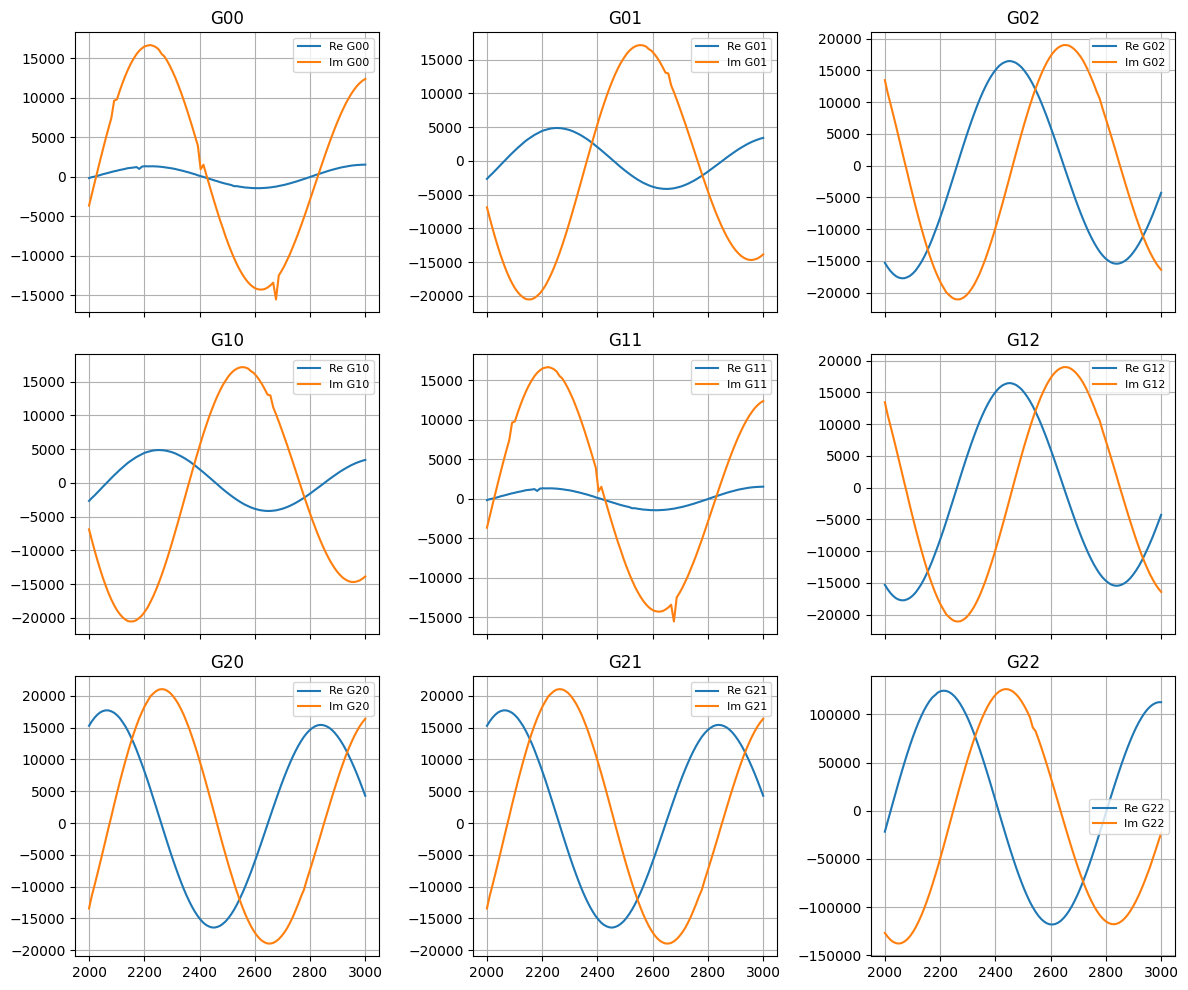

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True)

for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.plot(r, Ge[:, i, j].real, label=f'Re G{i}{j}')
        ax.plot(r, Ge[:, i, j].imag, label=f'Im G{i}{j}')
        ax.set_title(f"G{i}{j}")
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


# Radiation Pattern

In [28]:
from MieSppForce.simulation import SphericalGrid, CylindricalGrid

r_multiplier = 10

# r = 2000 *ureg.nm

r = r_multiplier * base_config.wl

gridXoZ = SphericalGrid(
    r=r,
    theta=np.linspace(-np.pi/2, np.pi/2, 200)*ureg.rad,
    phi=0* ureg.radian
)

gridYoZ =  SphericalGrid(
    r=r,
    theta=np.linspace(-np.pi/2, np.pi/2, 200)*ureg.rad,
    phi=np.pi/2* ureg.radian
)

gridXoY = CylindricalGrid(
    r = r,
    phi = np.linspace(0,2*np.pi,200) * ureg.rad,
    z=0 * ureg.nm
)


In [29]:
from MieSppForce.simulation import FieldsCalculator, DiagramCalculator, DipoleCalculator

setattr(base_config, 'wl', 900 * ureg.nanometer)

XoY_diag_spp = DiagramCalculator(base_config, gridXoY).compute(field_type='spp')

XoZ_diag_air = DiagramCalculator(base_config, gridXoZ).compute(field_type='air')

YoZ_diag_air = DiagramCalculator(base_config, gridYoZ).compute(field_type='air')

XoZ_diag_sc = DiagramCalculator(base_config, gridXoZ).compute(field_type='sc')

YoZ_diag_sc = DiagramCalculator(base_config, gridYoZ).compute(field_type='sc')

XoZ_diag_reg = DiagramCalculator(base_config, gridXoZ).compute(field_type='reg')

YoZ_diag_reg = DiagramCalculator(base_config, gridYoZ).compute(field_type='reg')

XoZ_diag_tot = DiagramCalculator(base_config, gridXoZ).compute()

YoZ_diag_tot = DiagramCalculator(base_config, gridYoZ).compute()

XoZ_diag_spp = DiagramCalculator(base_config, gridXoZ).compute(field_type='spp')

YoZ_diag_spp = DiagramCalculator(base_config, gridYoZ).compute(field_type='spp')

Dipoles_res = DipoleCalculator(base_config).compute()

Force_res = OpticalForceCalculator(base_config).compute()

100%|██████████| 200/200 [00:00<00:00, 494.12it/s]


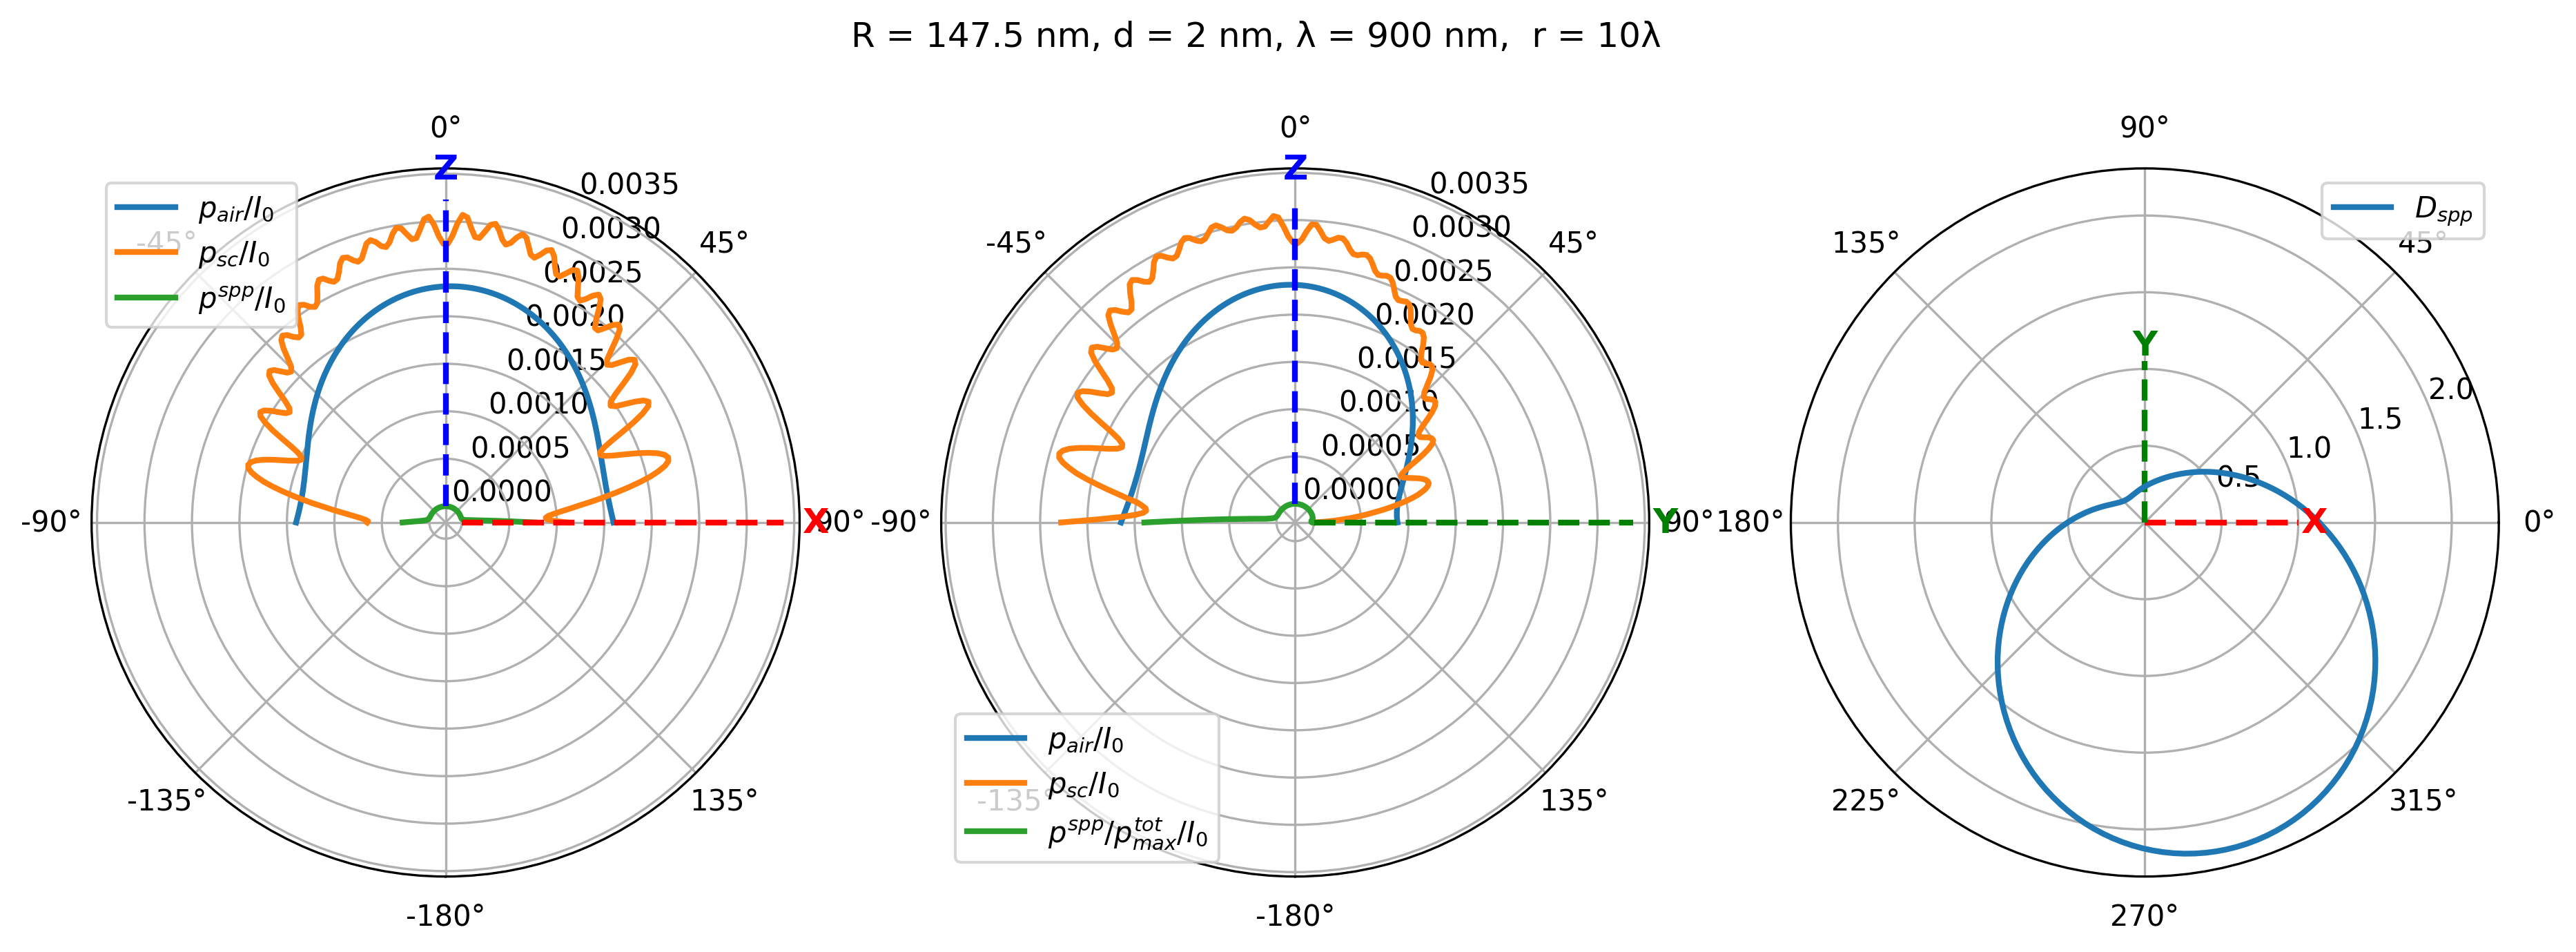

In [33]:
import numpy as np
import matplotlib.pyplot as plt


theta_YoZ_air, I_YoZ_air = YoZ_diag_air.as_array()[:,0], YoZ_diag_air.as_array()[:,1]
theta_XoZ_air, I_XoZ_air = XoZ_diag_air.as_array()[:,0], XoZ_diag_air.as_array()[:,1]

theta_XoY_spp, I_XoY_spp = XoY_diag_spp.as_array()[:,0], XoY_diag_spp.as_array()[:,1]

theta_YoZ_sc, I_YoZ_sc = YoZ_diag_sc.as_array()[:,0], YoZ_diag_sc.as_array()[:,1]
theta_XoZ_sc, I_XoZ_sc = XoZ_diag_sc.as_array()[:,0], XoZ_diag_sc.as_array()[:,1]

theta_YoZ_tot, I_YoZ_tot = YoZ_diag_tot.as_array()[:,0], YoZ_diag_tot.as_array()[:,1]
theta_XoZ_tot, I_XoZ_tot = XoZ_diag_tot.as_array()[:,0], XoZ_diag_tot.as_array()[:,1]

theta_YoZ_spp, I_YoZ_spp = YoZ_diag_spp.as_array()[:,0], YoZ_diag_spp.as_array()[:,1]
theta_XoZ_spp, I_XoZ_spp = XoZ_diag_spp.as_array()[:,0], XoZ_diag_spp.as_array()[:,1]

theta_YoZ_reg, I_YoZ_reg = YoZ_diag_reg.as_array()[:,0], YoZ_diag_reg.as_array()[:,1]
theta_XoZ_reg, I_XoZ_reg = XoZ_diag_reg.as_array()[:,0], XoZ_diag_reg.as_array()[:,1]

I0 = base_config.c_const.magnitude*base_config.eps0_const.magnitude/2


dips = Dipoles_res.as_dict()

px = dips['px'].magnitude.real
py = dips['py'].magnitude.real
pz = dips['pz'].magnitude.real
mx = dips['mx'].magnitude.real
my = dips['my'].magnitude.real
mz = dips['mz'].magnitude.real

forces = Force_res.as_dict()

Fxcross = forces['Fxcross'].magnitude
Fycross = forces['Fycross'].magnitude  
Fzcross = forces['Fzcross'].magnitude

Fcross_norm = np.sqrt(np.abs(Fxcross)**2 + np.abs(Fycross)**2 + np.abs(Fzcross)**2)

p_norm = np.sqrt(np.abs(px)**2 + np.abs(py)**2 + np.abs(pz)**2)
m_norm = np.sqrt(np.abs(mx)**2 + np.abs(my)**2 + np.abs(mz)**2)

fig, ax = plt.subplots(
    1, 3, figsize=(15, 5), dpi=300,
    subplot_kw={'projection': 'polar'}
)

def add_axis_line(ax, theta, label, color="k"):
    r_arrow = ax.get_rmax()
    ax.plot([theta, theta], [0, r_arrow], color=color, lw=2, ls='--')
    ax.text(theta, r_arrow*1.1, label, ha='center', va='center', fontsize=12, fontweight='bold', color=color)

# --- XoZ ---
ax[0].set_theta_offset(np.pi/2)
ax[0].set_theta_direction(-1)
ax[0].set_thetalim(-np.pi, np.pi)


ax[0].plot(theta_XoZ_air, I_XoZ_air/I0, lw=2, label='$p_{air}/I_0$')
ax[0].plot(theta_XoZ_sc, I_XoZ_sc/I0, lw=2, label='$p_{sc}/I_0$')
#ax[0].plot(theta_XoZ_reg, I_XoZ_reg/I0, lw=2, label='$p^{sc+air}/I_0$')
ax[0].plot(theta_XoZ_spp, I_XoZ_spp/I0, lw=2, label='$p^{spp}/I_0$')

# ax[0].arrow(np.pi/2-np.atan2(pz, px), 0, 0, np.sqrt(np.abs(px)**2 + np.abs(pz)**2)/p_norm, color='b', width = 0.05, label='$p_{zx}/|p|$')
# ax[0].arrow(np.pi/2-np.atan2(mz, mx), 0, 0, np.sqrt(np.abs(mx)**2 + np.abs(mz)**2)/m_norm, color='r', width = 0.05, label='$m_{zx}/|m|$')

# ax[0].arrow(np.pi/2-np.atan2(Fzcross, Fxcross), 0, 0, np.sqrt(np.abs(Fxcross)**2 + np.abs(Fzcross)**2)/Fcross_norm, color='g', width = 0.05, label='$F_{zx}^{cross}/|F^{cross}|$')

add_axis_line(ax[0], 0, "Z", color="b")
add_axis_line(ax[0], np.pi/2, "X", color="r")
ax[0].legend()


# --- YoZ ---
ax[1].set_theta_offset(np.pi/2)
ax[1].set_theta_direction(-1)
ax[1].set_thetalim(-np.pi, np.pi)



ax[1].plot(theta_YoZ_air, I_YoZ_air/I0, lw=2, label='$p_{air}/I_0$')
ax[1].plot(theta_YoZ_sc, I_YoZ_sc/I0, lw=2, label='$p_{sc}/I_0$')
#ax[1].plot(theta_YoZ_reg, I_YoZ_reg/I0, lw=2, label='$p^{air+sc}/p^{tot}_{max}/I_0$')
ax[1].plot(theta_YoZ_spp, I_YoZ_spp/I0, lw=2, label='$p^{spp}/p^{tot}_{max}/I_0$')

# ax[1].arrow(np.pi/2-np.atan2(pz, py), 0, 0, np.sqrt(np.abs(py)**2 + np.abs(pz)**2)/p_norm, color='b', width = 0.05, label='$p_{zy}/|p|$')
# ax[1].arrow(np.pi/2-np.atan2(mz, my), 0, 0, np.sqrt(np.abs(my)**2 + np.abs(mz)**2)/m_norm, color='r', width = 0.05, label='$m_{zy}/|m|$')

# ax[1].arrow(np.pi/2-np.atan2(Fzcross, Fycross), 0, 0, np.sqrt(np.abs(Fycross)**2 + np.abs(Fzcross)**2)/Fcross_norm, color='g', width = 0.05, label='$F_{zy}^{cross}/|F^{cross}|$')

add_axis_line(ax[1], 0, "Z", color="b")
add_axis_line(ax[1], np.pi/2, "Y", color="g")
ax[1].legend()


# --- XoY ---
ax[2].set_theta_zero_location("E")
ax[2].set_theta_direction(1)
add_axis_line(ax[2], 0, "X", color="r")
add_axis_line(ax[2], np.pi/2, "Y", color="g")

ax[2].plot(theta_XoY_spp, I_XoY_spp, lw=2, label='$D_{spp}$')
# ax[2].arrow(np.atan2(py, px), 0, 0, np.sqrt(np.abs(px)**2 + np.abs(py)**2)/p_norm, color='b', width = 0.05, label='$p_{xy}/|p|$')
# ax[2].arrow(np.atan2(my, mx), 0, 0, np.sqrt(np.abs(my)**2 + np.abs(mx)**2)/m_norm, color='r', width = 0.05, label='$m_{xy}/|m|$')

# ax[2].arrow(np.atan2(Fycross, Fxcross), 0, 0, np.sqrt(np.abs(Fycross)**2 + np.abs(Fxcross)**2)/Fcross_norm, color='g', width = 0.05, label='$F_{xy}^{cross}/|F^{cross}|$')


ax[2].legend()

plt.suptitle(f"R = {base_config.R.to(ureg.nm).magnitude} nm, d = {base_config.dist.to(ureg.nm).magnitude} nm, λ = {base_config.wl.to(ureg.nm).magnitude} nm,  r = {r_multiplier}λ")

plt.show()

In [ ]:
import numpy as np

def ellipse_coords(px, pz, npoints=100):
    t = np.linspace(0, 2*np.pi, npoints)
    x = np.real(px * np.exp(-1j*t))
    z = np.real(pz * np.exp(-1j*t))
    return x, z

fig, ax = plt.subplots(figsize=(5,5))
x, z = ellipse_coords(py, px)
ax.plot(x, z, 'b', label='траектория диполя')

# вычисляем угол большой оси
Ax, Az = abs(py), abs(px)
dphi = np.angle(px) -np.angle(py)
theta =  0.5*np.arctan2(2*Ax*Az*np.cos(dphi), Ax**2 - Az**2)

# рисуем главную ось
r = np.sqrt(Ax**2 + Az**2)
ax.arrow(0, 0, r*np.cos(theta), r*np.sin(theta), color='r', width=0.5*1e-33, label='главная ось')

ax.set_aspect('equal')
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.legend()
plt.show()


# SPP Directivity and SPP Force

In [2]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator,SweepRunner

grid = CylindricalGrid(
    r=np.linspace(0,3000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.1]) * ureg.nm
)

gridFF = CylindricalGrid(
    r=20*base_config.wl,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

In [3]:
sweep_res, diagrams, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False, None, 'spp').run()

Sweeping 'wl':   0%|          | 0/100 [00:00<?, ?step/s]

  0%|          | 0/100 [00:00<?, ?it/s]

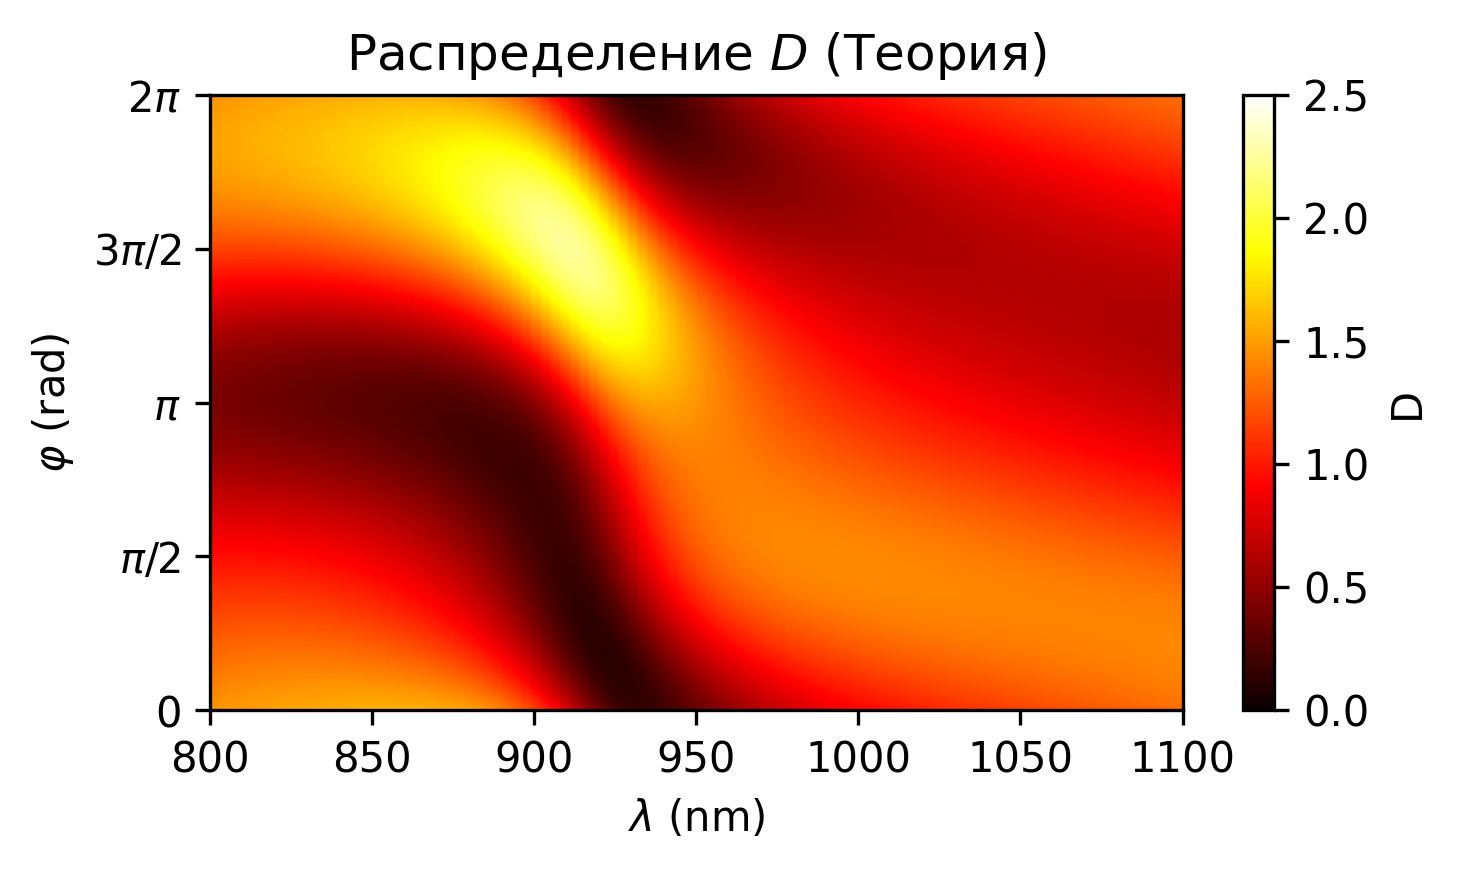

In [4]:
import numpy as np
import matplotlib.pyplot as plt

diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot = diagrams.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot.columns.min()), float(pivot.columns.max()),
        float(pivot.index.min()),   float(pivot.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (Теория)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
plt.savefig('plots/D_map_more.png', dpi=300)
plt.show()

Sweeping 'wl':   0%|          | 0/100 [01:13<?, ?step/s]


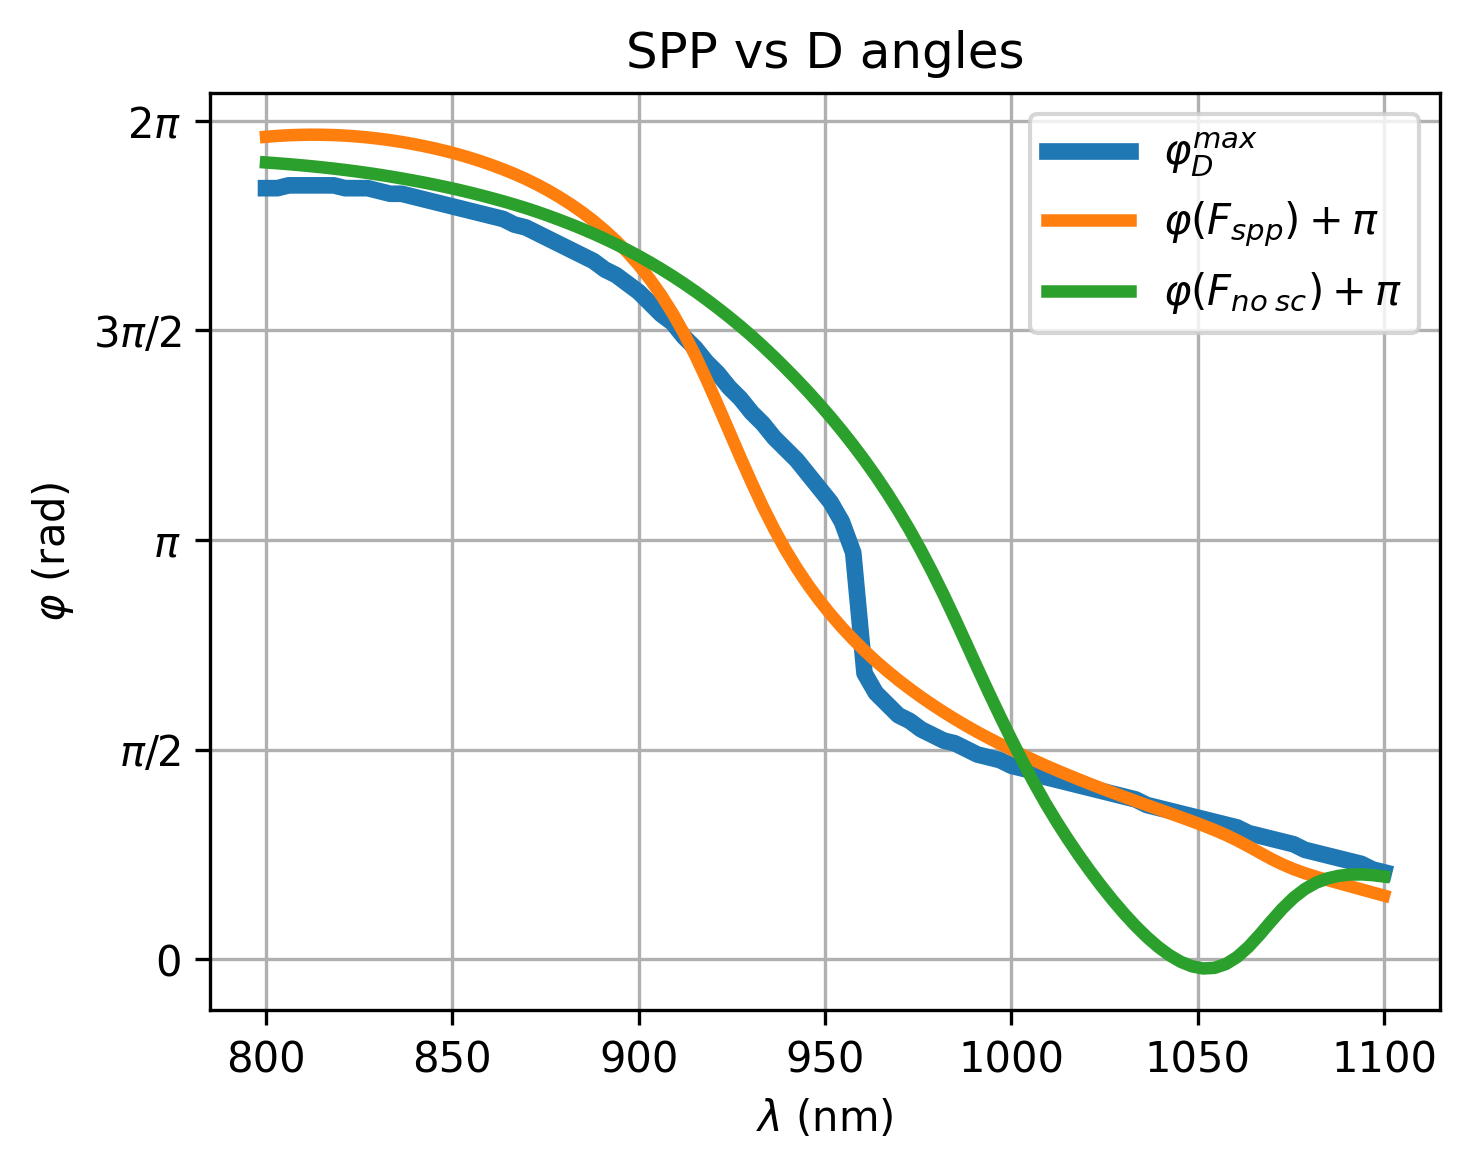

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. phi_max из диаграмм ---
diagrams["phi"] = diagrams["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams["wl"]  = diagrams["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

phi_max = (
    diagrams.loc[diagrams.groupby("wl")["D"].idxmax()][["wl", "phi"]]
    .rename(columns={"phi": "phi_max"})
)

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fy = sweep_res["Fy"].apply(lambda x: x.to("N").magnitude).to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fxm0 = sweep_res["Fxm0"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fxcross = sweep_res["Fxcross"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fycross = sweep_res["Fycross"].apply(lambda x: x.to("N").magnitude).to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross

Fxspp = sweep_res["Fxspp"].apply(lambda x: x.to("N").magnitude).to_numpy()
Fyspp = sweep_res["Fyspp"].apply(lambda x: x.to("N").magnitude).to_numpy()


theta_F = np.arctan2(Fy, Fx)

theta_F_nosc = np.arctan2(Fy, Fx_nosc)

theta_F_nosc_noncross = np.arctan2(Fy_nosc_noncross, Fx_nosc_noncross)

theta_F_spp = np.arctan2(Fyspp, Fxspp)


df_forces = pd.DataFrame({"wl": wl, "thetaFspp": theta_F_spp, "thetaFnosc_nocross": theta_F_nosc_noncross, "thetaFnosc": theta_F_nosc, "theta_F": theta_F })


df_plot = pd.merge(phi_max, df_forces, on="wl")


plt.figure(figsize=(5,4), dpi=300)

# plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", lw=4)
# plt.plot(df_plot["wl"], df_plot["theta_F"], label="$\\varphi_F$", lw=4)

plt.plot(df_plot["wl"], df_plot["phi_max"], label="$\\varphi_D^{max}$", lw=4)
plt.plot(df_plot["wl"], df_plot["thetaFspp"]+np.pi, label="$\\varphi(F_{spp})+\\pi$",  lw=3)

#plt.plot(df_plot["wl"], df_plot["thetaFnosc_nocross"]+np.pi, label="$\\varphi(F_{spp} + F_{\\int_0^1})+\\pi$",  lw=3)

plt.plot(df_plot["wl"], np.unwrap(df_plot["thetaFnosc"])+np.pi, label="$\\varphi(F_{no \\;sc})+\\pi$",  lw=3)

#plt.plot(df_plot["wl"], np.abs(df_plot["phi_max"]-df_plot["thetaFspp"]-np.pi), label="delta phi", marker="o")
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]
plt.yticks(yticks, yticklabels)

plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("SPP vs D angles")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/SPP_F_angles_more.png', dpi=300)
plt.show()

In [ ]:
sweep_res_air, diagrams_air, _ = SweepRunner(base_config, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, True, True, False, None, 'air').run()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

diagrams_air["phi"] = diagrams_air["phi"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)
diagrams_air["wl"]  = diagrams_air["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x)

pivot_air = diagrams_air.pivot(index="phi", columns="wl", values="D")

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    pivot_air.values.astype(float),
    aspect="auto",
    origin="lower",
    extent=[
        float(pivot_air.columns.min()), float(pivot_air.columns.max()),
        float(pivot_air.index.min()),   float(pivot_air.index.max())
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D_{air}$ (Theory)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('field/D_map_air.png', dpi=300)
plt.show()

In [ ]:
#Free Space

base_config_free_space = SimulationConfig(
    wl = 900 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(0),
    a_angle = 0,
    phase= 0,
    substrate='Air'
)

sweep_res_free_space, _, _ = SweepRunner(base_config_free_space, 'wl', np.linspace(800, 1100, 100)*ureg.nanometer, True, False, True, False).run()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])
Fxcross_norm   =  np.array([f / F0 for f in Fxcross])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])
Fycross_norm   =  np.array([f / F0 for f in Fycross])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 5),dpi=300, sharex=True)

#  X-компонента
# axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=3)
axs[0].plot(wl, Fxnocross_norm, label="$(F_x^{spp}+F_{x,\\;\\int_0^1} )/ F_0^{max}$", lw=3)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{spp} / F_0^{max}$", lw=3)
axs[0].plot(wl, Fxcross_norm, label="$F_x^{cross} / F_0^{max}$", lw=3)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
axs[1].plot(wl, Fynocross_norm, label="$(F_y^{spp}+F_{y,\\;\\int_0^1})/ F_0^{max}$", lw=3)
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm, label="$F_y^{cross} / F_0^{max}$", lw=3)

# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/SPP_Force_Components_more.png', dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()

Fx01 = Fx_nosc_noncross - Fxspp
Fy01 = Fy_nosc_noncross - Fyspp



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])
Fxcross_norm   =  np.array([f / F0 for f in Fxcross])
Fx01  =  np.array([f / F0 for f in Fx01])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])
Fycross_norm   =  np.array([f / F0 for f in Fycross])
Fy01  =  np.array([f / F0 for f in Fy01])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 5),dpi=300, sharex=True)

#  X-компонента
# axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
#axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=3)
axs[0].plot(wl, Fx01, label="$F_{x,\\;\\int_0^1} / F_0^{max}$", lw=3)
# axs[0].plot(wl, Fxspp_norm, label="$F_x^{spp} / F_0^{max}$", lw=3)
axs[0].plot(wl, Fxcross_norm, label="$F_x^{cross} / F_0^{max}$", lw=3)

axs[0].plot(wl, Fxcross_norm+Fx01, label="$(F_x^{cross} +F_{x,\\;\\int_0^1})  / F_0^{max}$", ls='--',lw=3)

# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
#axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=3)
axs[1].plot(wl, Fy01, label="$F_{y,\\;\\int_0^1}/ F_0^{max}$", lw=3)
#axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm, label="$F_y^{cross} / F_0^{max}$", lw=3)
axs[1].plot(wl, Fycross_norm+Fy01, label="$(F_y^{cross} +F_{y,\\;\\int_0^1})  / F_0^{max}$", ls='--',lw=3)


# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/Force_01_and_Cross.png', dpi=300)
plt.show()

In [ ]:
fxfy_comsol = np.loadtxt('fx_fy.txt', delimiter=',')

In [ ]:
plt.figure(figsize=(4,2), dpi=300)
plt.plot(wl, Fx/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,1]/F0.magnitude, label='Theory', lw=2)
plt.ylabel('$F_x/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
#plt.savefig('Fx_coms_python.png')


In [ ]:

plt.figure(figsize=(4,2), dpi=300)
plt.plot(wl, Fy/F0.magnitude, label='COMSOL', lw=2)
plt.plot(fxfy_comsol[:,0], fxfy_comsol[:,2]/F0.magnitude, label='Theory', lw=2)
plt.ylabel('$F_y/F_0^{max}$')
plt.xlabel('$\\lambda$, nm')
plt.legend()
plt.grid()
plt.xlim(wl[0], wl[-1])
plt.tight_layout()
#plt.savefig('Fy_coms_python.png')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
#axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=2)
#axs[0].plot(wl, Fxnocross_norm, label="Fx_nosc_nocross / F0", lw=2)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
# axs[0].set_ylabel("$F_x^{spp} / F_0^{max}$")
axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=2)
# axs[1].plot(wl, Fynocross_norm, label="Fy_nosc_nocross / F0", marker="^")
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

axs[0].set_xlim(wl[0],wl[-1])

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/F_nosc_and_SPP_Force_Components.png', dpi=300)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F0 = np.max(np.abs(sweep_res_free_space['Fz'].to_numpy()))

# --- 2. Угол силы ---
Fx = sweep_res["Fx"].to_numpy()
Fy = sweep_res["Fy"].to_numpy()
wl = sweep_res["wl"].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

Fxe0 = sweep_res["Fxe0"].to_numpy()
Fxm0 = sweep_res["Fxm0"].to_numpy()

Fxcross = sweep_res["Fxcross"].to_numpy()
Fycross = sweep_res["Fycross"].to_numpy()

Fx_nosc = Fx - Fxe0 - Fxm0

Fx_nosc_noncross = Fx_nosc - Fxcross
Fy_nosc_noncross = Fy - Fycross


Fxspp = sweep_res["Fxspp"].to_numpy()
Fyspp = sweep_res["Fyspp"].to_numpy()



Fx_norm      = np.array([f / F0 for f in Fx])
Fxnosc_norm  = np.array([f / F0 for f in Fx_nosc])
Fxnocross_norm = np.array([f / F0 for f in Fx_nosc_noncross])
Fxspp_norm   =  np.array([f / F0 for f in Fxspp])

Fy_norm      =  np.array([f / F0 for f in Fy])
Fynocross_norm =np.array([f / F0 for f in Fy_nosc_noncross])
Fyspp_norm   = np.array([f / F0 for f in Fyspp])

# --- графики ---
fig, axs = plt.subplots(2, 1, figsize=(5, 4.5),dpi=300, sharex=True)

#  X-компонента
#axs[0].plot(wl, Fx_norm, label="Fx / F0", marker="o")
axs[0].plot(wl, Fxnosc_norm, label="$F_x^{no\\;sc}/F_0^{max}$", lw=2)
axs[0].plot(wl, Fxnocross_norm, label="$(F_x^{SPP} + F_{x\\;\\int_0^1}) / F_0^{max}$", lw=2)
axs[0].plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)

axs[0].legend()
axs[0].grid(True)

# Y-компонента
axs[1].plot(wl, Fy_norm, label="$F_y / F_0^{max}$", lw=2)
axs[1].plot(wl, Fynocross_norm, label="$(F_y^{SPP} + F_{y\\;\\int_0^1}) / F_0^{max}$", lw=2)
axs[1].plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)
# axs[1].set_ylabel("$F_y^{spp}$ / $F_0^{max}$")
axs[1].set_xlabel("$\\lambda$ (nm)")
axs[1].legend()
axs[1].grid(True)

axs[0].set_xlim(wl[0],wl[-1])

plt.suptitle("Force Components")
plt.tight_layout()
plt.savefig('plots/F_nosc_and_SPP_Force_Components_more.png', dpi=300)
plt.show()

In [ ]:

# --- графики ---
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5),dpi=300, sharex=True)

ax.plot(wl, Fxspp_norm, label="$F_x^{SPP} / F_0^{max}$", lw=2)
ax.plot(wl, Fyspp_norm, label="$F_y^{spp} / F_0^{max}$", lw=2)

ax.set_xlabel("$\\lambda$ (nm)")
ax.legend()
ax.grid(True)

ax.set_xlim(wl[0],wl[-1])

plt.suptitle("SPP Force Components")
plt.tight_layout()
#plt.savefig('field/SPP_Force_Components.png', dpi=300)
plt.show()

In [ ]:
data = pd.read_csv('relHphi_wl_m.csv', skiprows=4)

wls = data['% lambda0 (nm)'].unique()

phii = np.linspace(0, 2*np.pi, 200)

H_phi = np.zeros((len(wls), len(phii)), dtype=complex)

M_max =2 
for i in range(len(wls)):
    for j in range(2*M_max+1):
        H_phi[i,:] += (data['real(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j] + 1j*data['imag(ewfd.relHphi) (A/m), Point: 13'][i*(2*M_max+1)+j])*np.exp(-1j*(-M_max+j)*phii)
        
from scipy.integrate import trapezoid
D_coms = np.zeros_like(H_phi)

for i in range(len(wls)):
    integr = trapezoid(np.abs(H_phi[i,:])**2, phii)
    D_coms [i, :] =  2*np.pi* np.abs(H_phi[i,:])**2 /  integr   

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3), dpi=300)

plt.imshow(
    D_coms.T.real,
    aspect="auto",
    origin="lower",
    extent=[
        wls[0],   wls[-1],
        phii[0], phii[-1],
    ],
    cmap="hot",
    vmin=0, vmax=2.5
)

plt.colorbar(label="D")
plt.xlabel("$\\lambda$ (nm)")
plt.ylabel("$\\varphi$ (rad)")
plt.title("Распределение $D$ (COMSOL)")

# Установка делений по оси Y в радианах
yticks = [0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi]
yticklabels = ["$0$", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"]

plt.yticks(yticks, yticklabels)

plt.tight_layout()
#plt.savefig('D_map_comsol.png')
plt.show()

# Fcross vs Air Scattering 

In [ ]:
base_config = SimulationConfig(
    wl = 926 * ureg.nanometer,
    R =  (295/2) * ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = np.pi/4,
    phase= np.pi/2
)

In [ ]:
from MieSppForce.simulation import SphericalGrid, DiagramCalculator, OpticalForceCalculator

import matplotlib.pyplot as plt


SphGrid = SphericalGrid(r = base_config.wl*3,
                        theta= np.linspace(-np.pi/2, np.pi/2, 100)*ureg.rad,
                        phi= 0 * ureg.rad)

Field_Rad = FieldsCalculator(base_config).compute(SphGrid)

forces_single = OpticalForceCalculator(base_config).compute()

In [ ]:
fycross = forces_single.as_dict()['Fycross']
fzcross = forces_single.as_dict()['Fzcross']
fxcross = forces_single.as_dict()['Fxcross']

fx = forces_single.as_dict()['Fx']
fz = forces_single.as_dict()['Fz']

fxe0 = forces_single.as_dict()['Fxe0']
fze0 = forces_single.as_dict()['Fze0']

fxm0 = forces_single.as_dict()['Fxm0']
fzm0 = forces_single.as_dict()['Fzm0']




EXX = Field_Rad.df['Ex'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

EYY = Field_Rad.df['Ey'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

EZZ = Field_Rad.df['Ez'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HXX = Field_Rad.df['Hx'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HYY = Field_Rad.df['Hy'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()

HZZ = Field_Rad.df['Hz'].apply(lambda x: x.magnitude if hasattr(x, "magnitude") else x).to_numpy()


Sx = 0.5*np.real(EYY*HZZ.conj() - EZZ * HYY.conj() )
Sy = 0.5*np.real(EZZ*HXX.conj() - EXX * HZZ.conj() )
Sz = 0.5*np.real(EXX*HYY.conj() - EYY * HZZ.conj() )

absS = np.sqrt(np.abs(Sx)**2 + np.abs(Sy)**2 + np.abs(Sz)**2)


THETA = np.linspace(-np.pi/2, np.pi/2, 100)


fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(5, 5))
ax.set_theta_offset(np.pi/2)

ax.arrow(np.atan2(fxcross,fzcross).magnitude, 0, 0, 1,  alpha = 0.5, width = 0.03, edgecolor = 'black', lw = 3, zorder = 5)
# ax.plot(THETA, absS)

ax.plot(THETA, (Sx*np.sin(THETA)+Sz*np.cos(THETA))/np.max(Sx*np.sin(THETA)+Sz*np.cos(THETA)))


In [ ]:
from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

grid = CylindricalGrid(
    r=np.linspace(0,2000, 100)*ureg.nm,
    phi=np.linspace(0, np.pi*2, 200)* ureg.radian,
    z=np.array([0.1]) * ureg.nm
)

In [ ]:
FiledSPP = FieldsCalculator(base_config).compute(grid, 'sub')
FiledAir = FieldsCalculator(base_config).compute(grid, 'air')
FiledFull = FieldsCalculator(base_config).compute(grid)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Ez'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


exx = FiledAir.df['Ex'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


eyy = FiledAir.df['Ey'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))


Err = exx * np.cos(phi_mesh) + eyy * np.sin(phi_mesh)

Epp = -1 *  exx * np.sin(phi_mesh) + eyy * np.cos(phi_mesh)

c = ax.pcolormesh(phi_mesh, r_mesh, comp_vals.real , shading='auto', cmap='bwr', vmax=1, vmin=-1)

fig.colorbar(c, ax=ax, label=f"{comp}")

# fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')

plt.tight_layout()

ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
# plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

comp ='Hz'

r_vals = FiledFull.df['r'].apply(lambda x: x.to('nm').magnitude).unique()
phi_vals = FiledFull.df['phi'].apply(lambda x: x.to('rad').magnitude).unique()

r_mesh, phi_mesh = np.meshgrid(r_vals, phi_vals, indexing='ij')

comp_vals = FiledFull.df[comp].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))


hxx = FiledFull.df['Hx'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))
hyy = FiledFull.df['Hy'].apply(lambda x: x.magnitude).values.reshape(len(r_vals), len(phi_vals))

Hrr = hxx * np.cos(phi_mesh) + hyy * np.sin(phi_mesh)

Hpp = -1 *  hxx * np.sin(phi_mesh) + hyy * np.cos(phi_mesh)


fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8, 6))

c = ax.pcolormesh(phi_mesh, r_mesh, Hpp.real, shading='auto', cmap='bwr',vmin=-1e-3, vmax=1e-3)


fig.colorbar(c, ax=ax, label=f"{comp}", format='%.0e')



ax.set_title(f"Распределение Re(rel{comp})")
plt.tight_layout()
#plt.savefig(f'field/real('+comp+').png', dpi=300 )
plt.show()